## __文本解码原理\-\-以MindNLP为例__

### 回顾：自回归语言模型

__根据前文预测下一个单词__
<div align=center><img src="https://openi.pcl.ac.cn/mindspore-courses/Step_into_LLMs/raw/commit/8f6e55c907ef7d2b616e8e3c4da76b065633c2ae/Season2.step_into_llm/03.Decoding/example.png"></div>

__一个文本序列的概率分布可以分解为每个词基于其上文的条件概率的乘积__
<div align=center><img src="https://openi.pcl.ac.cn/mindspore-courses/Step_into_LLMs/raw/commit/8d9110b0d7b8840d536880b7fceaf0df1b3e8354/Season2.step_into_llm/03.Decoding/P%e5%85%ac%e5%bc%8f.png"></div>

* 𝑊_0:初始上下文单词序列
* 𝑇: 时间步
* 当生成EOS标签时，停止生成。

__MindNLP/huggingface Transformers提供的文本生成方法__
<div align=center><img src="https://openi.pcl.ac.cn/mindspore-courses/Step_into_LLMs/raw/commit/8f6e55c907ef7d2b616e8e3c4da76b065633c2ae/Season2.step_into_llm/03.Decoding/3possible.png"></div>



__Greedy search__

在每个时间步𝑡都简单地选择概率最高的词作为当前输出词:

𝑤_𝑡=𝑎𝑟𝑔𝑚𝑎𝑥_𝑤 𝑃(𝑤|𝑤_(1:𝑡−1))

按照贪心搜索输出序列("The","nice","woman") 的条件概率为：0.5 x 0.4 = 0.2

缺点: 错过了隐藏在低概率词后面的高概率词，如：dog=0.5, has=0.9
![image.png](attachment:image.png =600x600)

__环境准备__

In [ ]:
#安装python 3.9版本的kernel
#%%capture captured_output
!/home/ma-user/anaconda3/bin/conda create -n python-3.9.0 python=3.9.0 -y --override-channels --channel https://mirrors.tuna.tsinghua.edu.cn/anaconda/pkgs/main
!/home/ma-user/anaconda3/envs/python-3.9.0/bin/pip install ipykernel

In [8]:
import json
import os

data = {
   "display_name": "python-3.9.0",
   "env": {
      "PATH": "/home/ma-user/anaconda3/envs/python-3.9.0/bin:/home/ma-user/anaconda3/envs/python-3.7.10/bin:/modelarts/authoring/notebook-conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ma-user/modelarts/ma-cli/bin:/home/ma-user/modelarts/ma-cli/bin"
   },
   "language": "python",
   "argv": [
      "/home/ma-user/anaconda3/envs/python-3.9.0/bin/python",
      "-m",
      "ipykernel",
      "-f",
      "{connection_file}"
   ]
}

if not os.path.exists("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/"):
    os.mkdir("/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/")

with open('/home/ma-user/anaconda3/share/jupyter/kernels/python-3.9.0/kernel.json', 'w') as f:
    json.dump(data, f, indent=4)

In [1]:
#安装mindspore2.4
!pip uninstall mindspore-gpu -y
!pip uninstall mindvision -y
!pip uninstall mindinsight -y
!pip install mindnlp-0.4.1-py3-none-any.whl
%env no_proxy='a.test.com,127.0.0.1,2.2.2.2'
%pip install https://ms-release.obs.cn-north-4.myhuaweicloud.com/2.4.0/MindSpore/unified/aarch64/mindspore-2.4.0-cp39-cp39-linux_aarch64.whl --trusted-host ms-release.obs.cn-north-4.myhuaweicloud.com -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: http://pip.modelarts.private.com:8888/repository/pypi/simple
Processing ./mindnlp-0.4.1-py3-none-any.whl
     |████████████████████████████████| 78 kB 39.9 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: mindnlp
    Found existing installation: mindnlp 0.3.0
    Uninstalling mindnlp-0.3.0:
      Successfully uninstalled mindnlp-0.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
modelarts 1.4.28 requires lxml==5.1.0, but you have lxml 4.9.3 which is incompatible.
modelarts 1.4.28 requires matplotlib==3.5.2, but you have matplotlib 3.5.1 which is incompatible.
modelarts 1.4.28 requires prettytable<=3.7.0, but you have prettytable 3.10.2 which is incompatible.
modelarts 1.4.28 requires requests==2.31.0, 

In [1]:
#greedy_search

from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

# generate text until the output length (which includes the context length) reaches 50
greedy_output = model.generate(input_ids, max_length=50)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

[WARNING] GE_ADPT(36162,ffff9d7f40b0,python):2024-12-03-21:20:47.447.323 [mindspore/ccsrc/utils/dlopen_macro.h:163] DlsymAscend] Dynamically load symbol aclmdlBundleGetModelId failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclmdlBundleGetModelId
[WARNING] GE_ADPT(36162,ffff9d7f40b0,python):2024-12-03-21:20:47.447.394 [mindspore/ccsrc/utils/dlopen_macro.h:163] DlsymAscend] Dynamically load symbol aclmdlBundleLoadFromMem failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclmdlBundleLoadFromMem
[WARNING] GE_ADPT(36162,ffff9d7f40b0,python):2024-12-03-21:20:47.447.413 [mindspore/ccsrc/utils/dlopen_macro.h:163] DlsymAscend] Dynamically load symbol aclmdlBundleUnload failed, result = /usr/local/Ascend/ascend-toolkit/latest/lib64/libascendcl.so: undefined symbol: aclmdlBundleUnload
[WARNING] GE_ADPT(36162,ffff9d7f40b0,python):2024-12-03-21:20:47.447.594 [mindspore/ccsrc/utils/dlopen_macro.h:163] Dl

  1%|1         | 7.61M/523M [00:00<?, ?B/s]

GPT2LMHeadModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`.`PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
[WARNING] DEVICE(36162,ffff9d7f40b0,python):2024-12-03-21:21:50.648.645 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:188] CheckVmmDriverVersion] Driver version is less than 24.0.0, vmm is disabled by default, drvier_version: 23.0.6


  0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with my dog. I'm not sure if I'll ever be able to walk with my dog.

I'm not sure if I'll


__Beam search__

Beam search通过在每个时间步保留最可能的 num_beams 个词，并从中最终选择出概率最高的序列来降低丢失潜在的高概率序列的风险。如图以 num_beams=2 为例:

("The","dog","has") : 0.4 * 0.9 = 0.36

("The","nice","woman") : 0.5 * 0.4 = 0.20

优点：一定程度保留最优路径

缺点：1. 无法解决重复问题；2. 开放域生成效果差

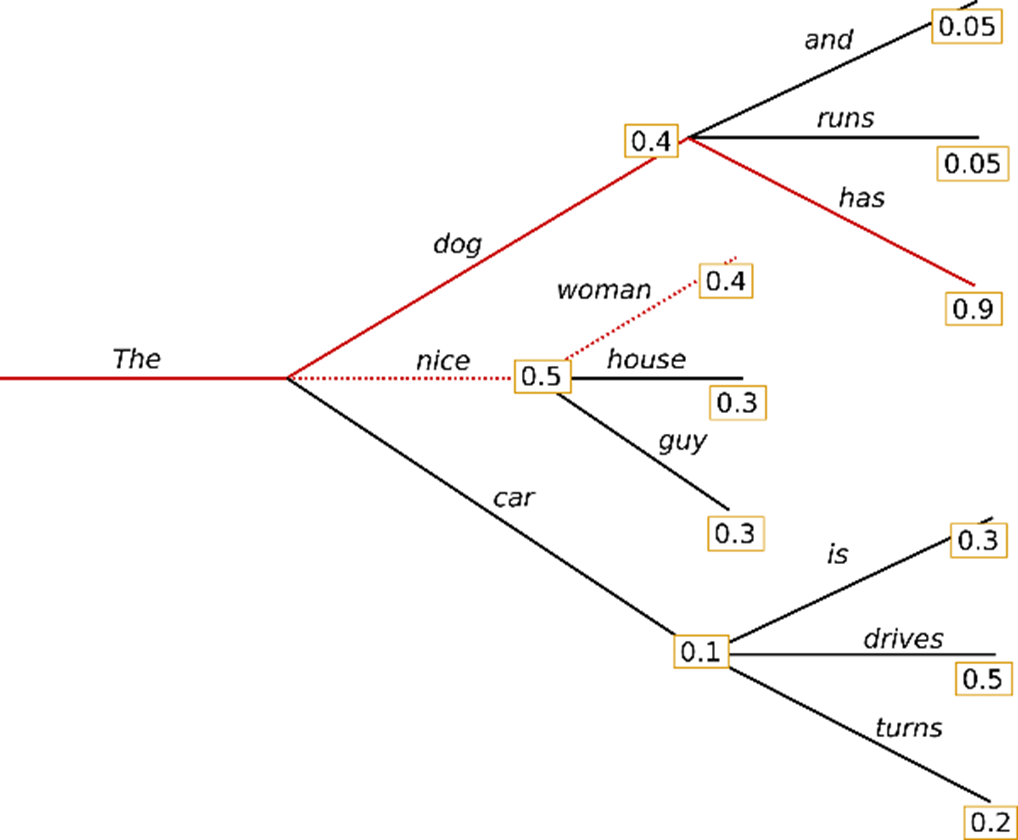

In [2]:
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

# activate beam search and early_stopping
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
print(100 * '-')

# set no_repeat_ngram_size to 2
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    early_stopping=True
)

print("Beam search with ngram, Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
print(100 * '-')

# set return_num_sequences > 1
beam_outputs = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, 
    num_return_sequences=5, 
    early_stopping=True
)

# now we have 3 output sequences
print("return_num_sequences, Output:\n" + 100 * '-')
for i, beam_output in enumerate(beam_outputs):
    print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))
print(100 * '-')


/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I'm not sure if I'll ever be able to walk with him again. I'm not sure if I'll
----------------------------------------------------------------------------------------------------
Beam search with ngram, Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break
----------------------------------------------------------------------------------------------------
return_num_sequences, Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog, but I'm not sure if I'l

__Beam search issues__
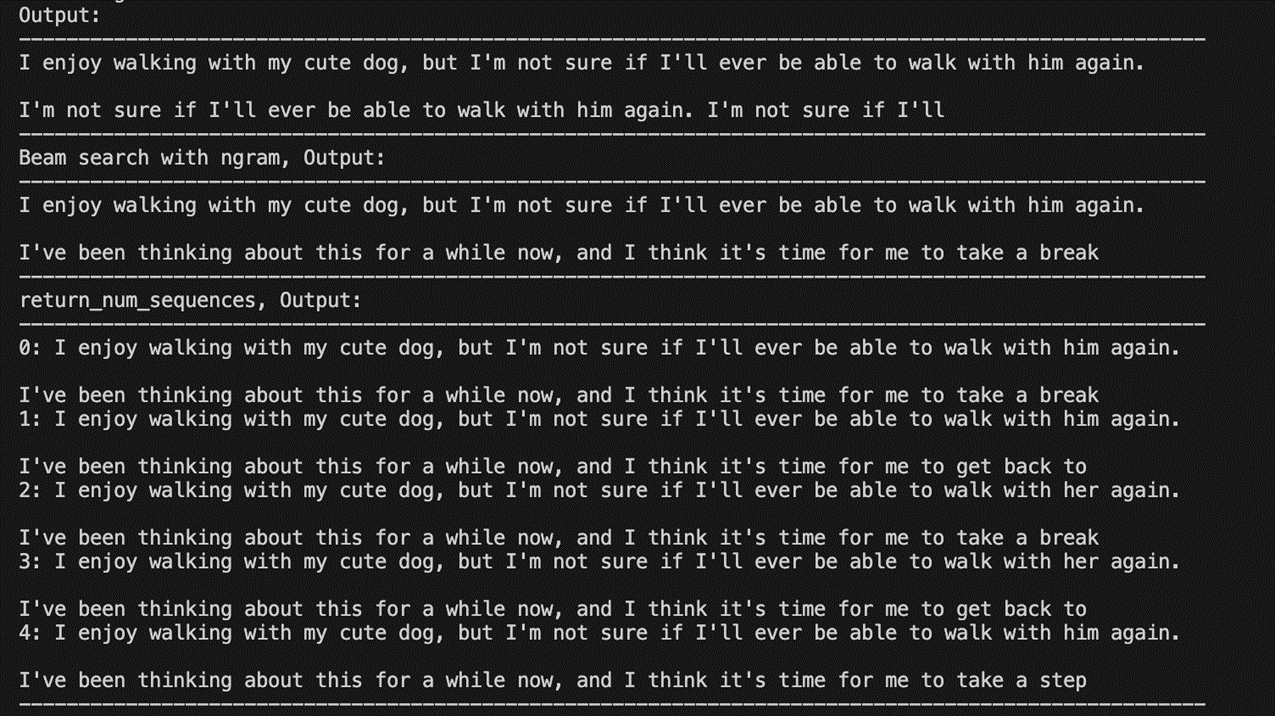
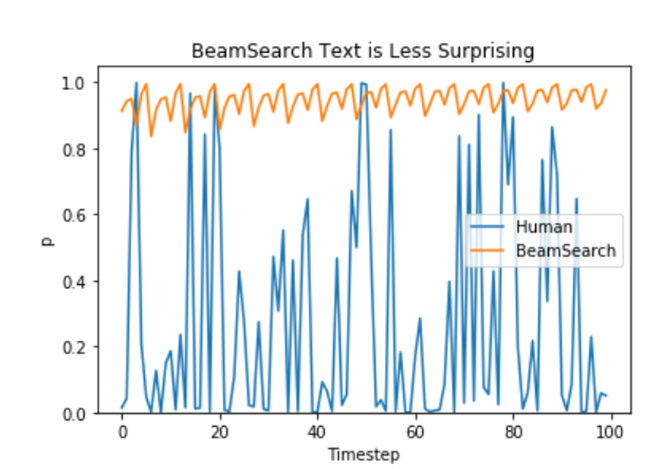

缺点：1. 无法解决重复问题；2. 开放域生成效果差


__Repeat problem__
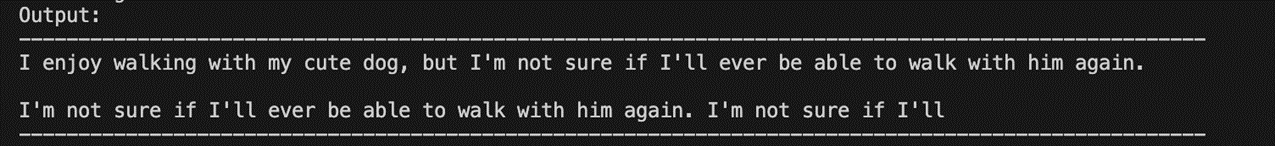
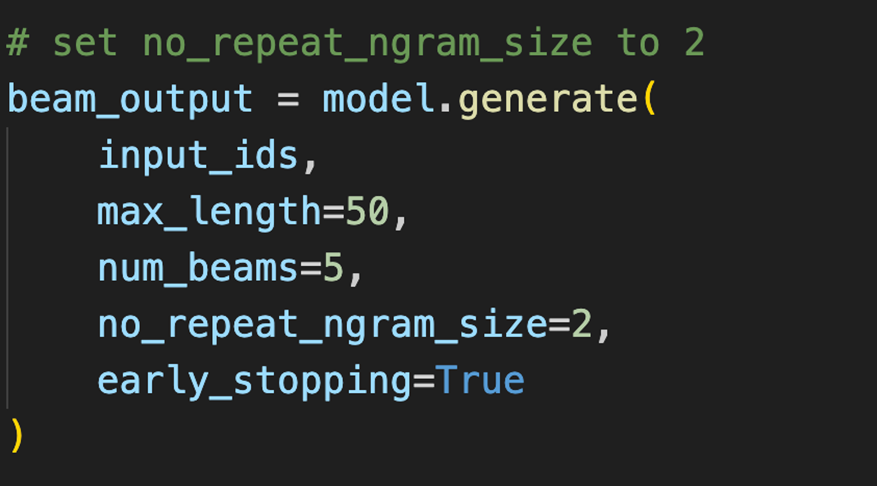

n-gram 惩罚:

将出现过的候选词的概率设置为 0

设置no_repeat_ngram_size=2 ，任意 2-gram 不会出现两次

Notice: 实际文本生成需要重复出现


__Sample__

根据当前条件概率分布随机选择输出词𝑤_𝑡 

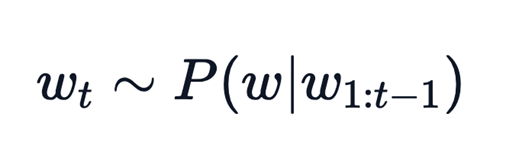

("car") ～P(w∣"The")
("drives") ～P(w∣"The","car")
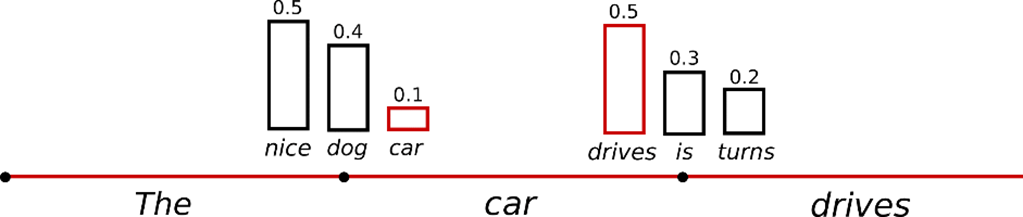

优点：文本生成多样性高

缺点：生成文本不连续


In [3]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog. That also makes me happy."


►Jan 29, 2017: Most kids comment on 'not caring or liking animals'

Copyright by WTEN - All rights reserved

Copyright by WTEN -


__Temperature__
降低softmax 的temperature使 P(w∣w1:t−1​)分布更陡峭

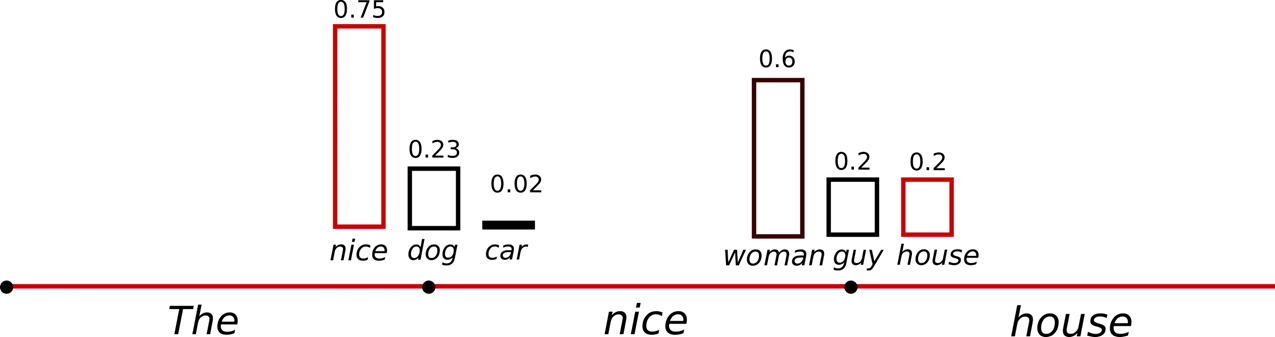

增加高概率单词的似然并降低低概率单词的似然


In [4]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(1234)
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=0,
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog who is very energetic and very friendly. I have a buddy who is a little shy and I'm very lonely. He is always near looking at me and laughing at me and asking me to help him out. I


__TopK sample__

选出概率最大的 K 个词，重新归一化，最后在归一化后的 K 个词中采样
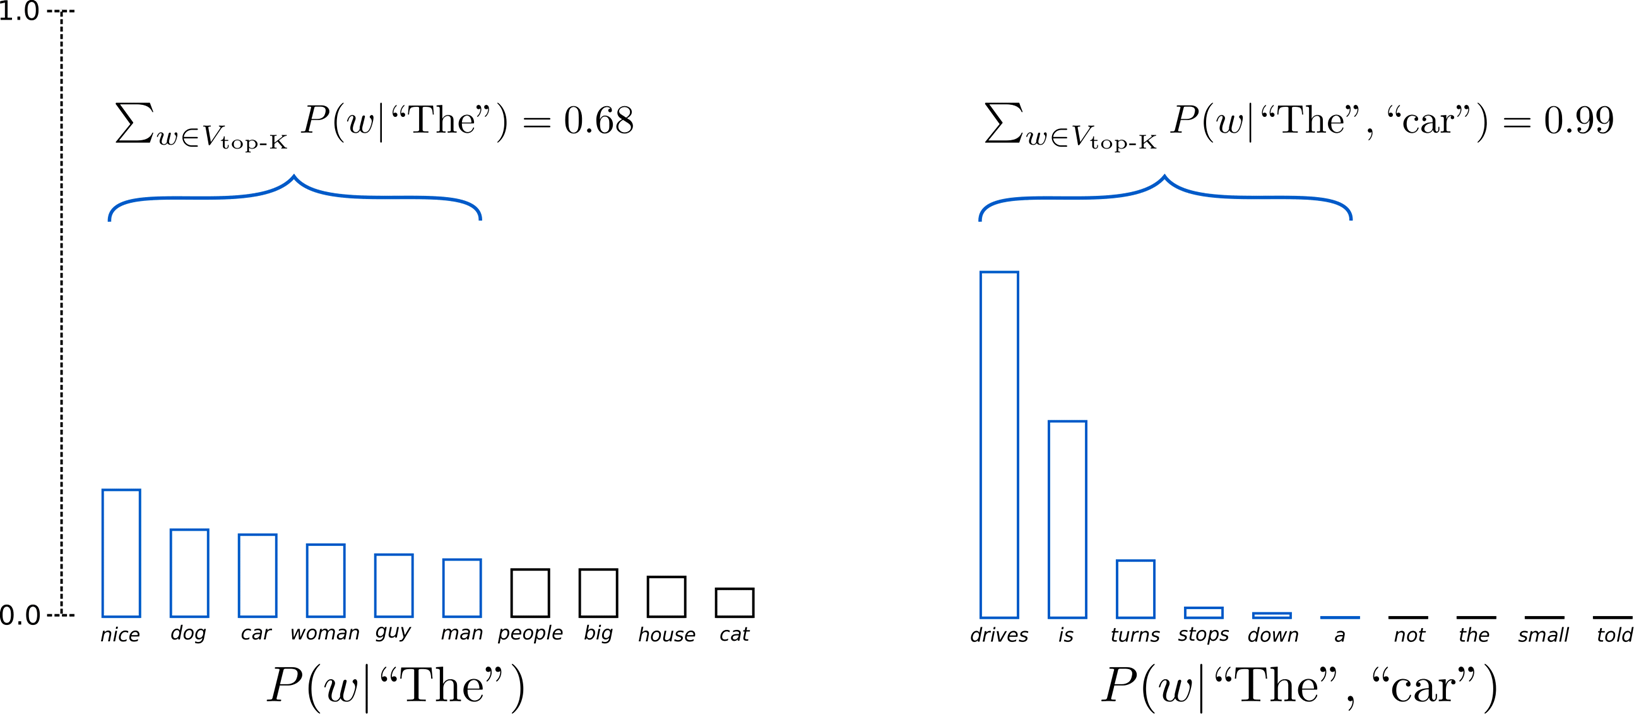


__TopK sample problems__

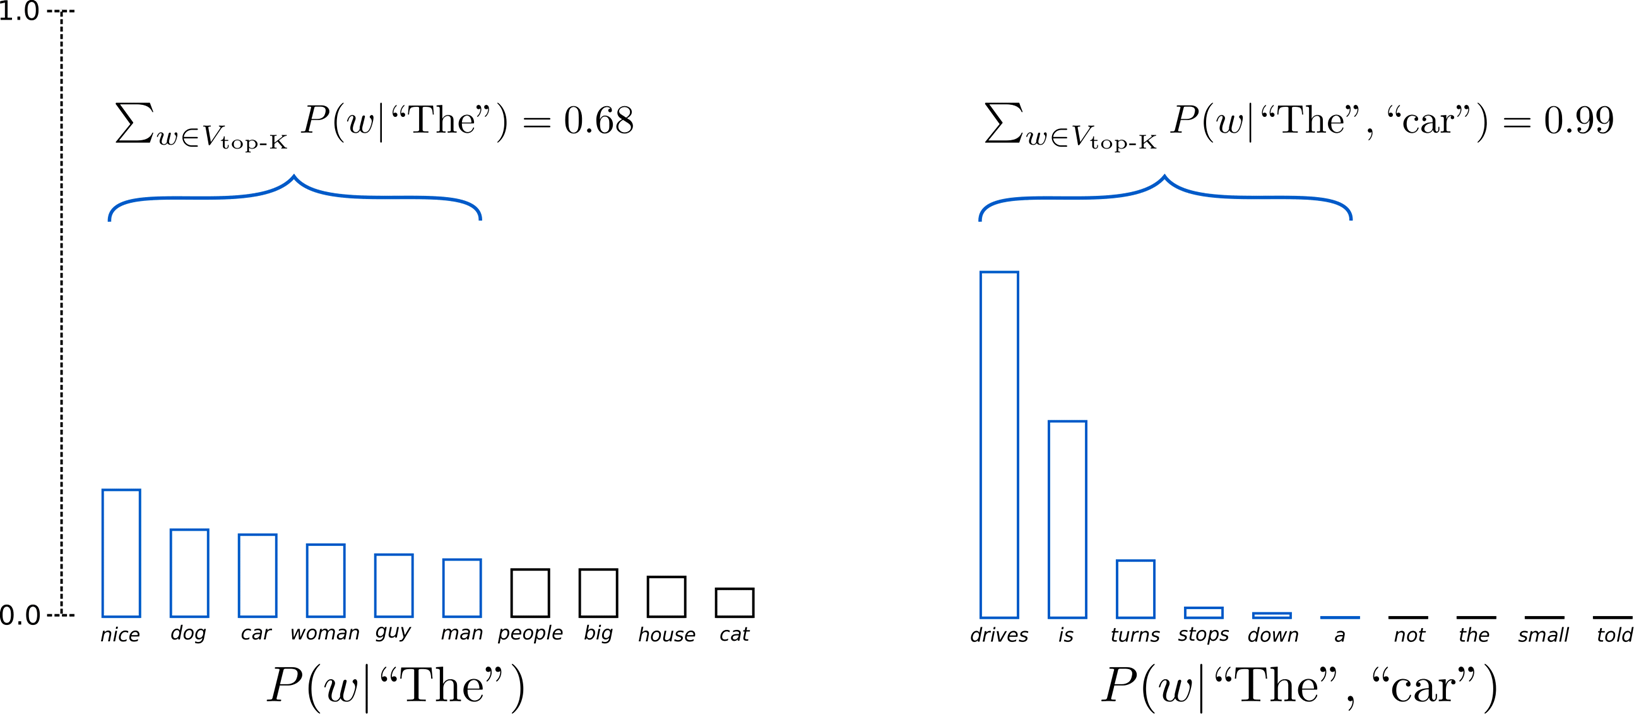

将采样池限制为固定大小 K ：
* 在分布比较尖锐的时候产生胡言乱语
* 在分布比较平坦的时候限制模型的创造力


In [5]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)
# activate sampling and deactivate top_k by setting top_k sampling to 0
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_k=50
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog. I really enjoy running, but I tend to have to go through school on time. The fact that they make me walk on time is such a cool thing.

I've had a lot of problems that


__Top-P sample__

在累积概率超过概率 p 的最小单词集中进行采样，重新归一化

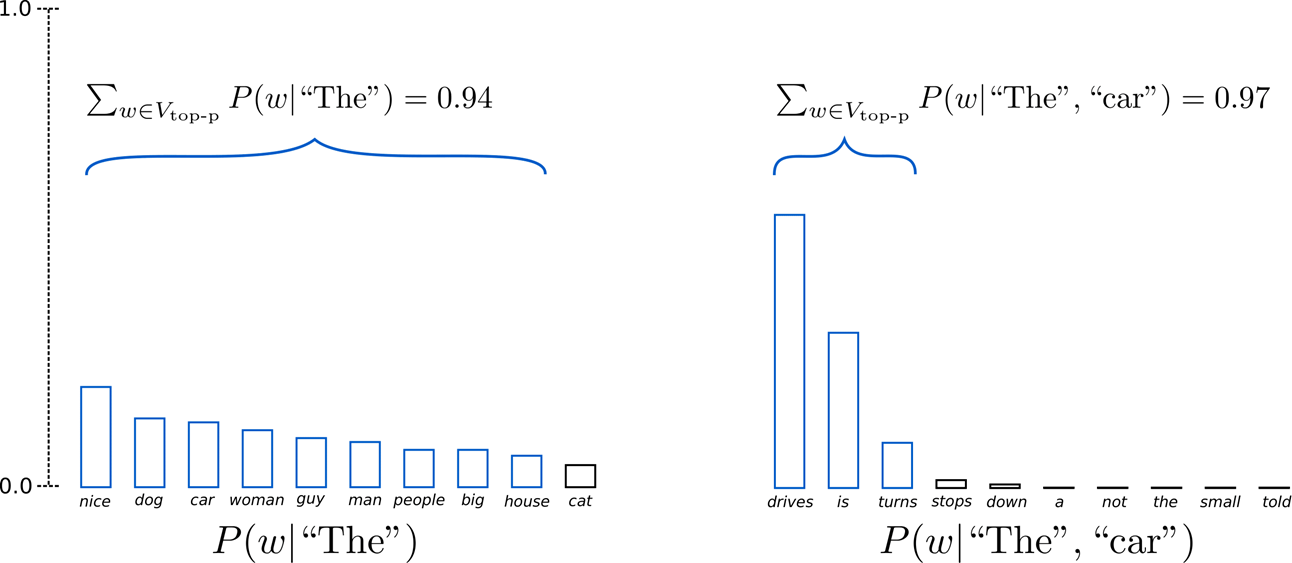

采样池可以根据下一个词的概率分布动态增加和减少


In [6]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)

# deactivate top_k sampling and sample only from 92% most likely words
sample_output = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=50, 
    top_p=0.92, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog as much as we do swim. There's also the experience of being in an area of my gym and getting lost and keeping track of how much I missed that thing. We also spend time sorting through some high quality


__top_k_top_p__

In [7]:
import mindspore
from mindnlp.transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

# encode context the generation is conditioned on
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='ms')

mindspore.set_seed(0)
# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = model.generate(
    input_ids,
    do_sample=True,
    max_length=50,
    top_k=5,
    top_p=0.95,
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: I enjoy walking with my cute dog," says Kelli. "I love having my dogs with me."

The two have two dogs, a Labrador retriever, and an American shepherd.

The dogs are both adopted by the Humane Society
1: I enjoy walking with my cute dog. I like being alone. I enjoy being alone in a room full of people."
2: I enjoy walking with my cute dog and playing with my dog," said her mother.

"I'm a very loving person and I'm very thankful for all of you who have been so supportive of our little girl," she added.


